In [1]:
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import colors, cm, pyplot as plt
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

In [2]:
CONVERTED_DATABASE = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/converted-databases/exp-dwm-test-run-190719_Hela_Ecoli_1to1_01-converted.sqlite'

# frame types for PASEF mode
FRAME_TYPE_MS1 = 0
FRAME_TYPE_MS2 = 8


In [3]:
db_conn = sqlite3.connect(CONVERTED_DATABASE)
ms1_frame_properties_df = pd.read_sql_query("select Id,Time from frame_properties where MsMsType == {}".format(FRAME_TYPE_MS1), db_conn)
ms1_frame_ids = tuple(ms1_frame_properties_df.Id)
db_conn.close()

We consider a pixel to be an m/z bin. To maintain consistency with previous labelled training sets, and because it looks good for visual inspection, we will keep the tiles to be 18.0 Da wide.

In [4]:
PIXELS_X = 910
PIXELS_Y = 910  # equal to the number of scan lines

MZ_MIN = 100.0
MZ_MAX = 1700.0
SCAN_MAX = PIXELS_Y
SCAN_MIN = 1

MZ_PER_TILE = 18.0
TILES_PER_FRAME = int((MZ_MAX - MZ_MIN) / MZ_PER_TILE) + 1

In [5]:
def mz_from_tile_pixel(tile_id, pixel_x):
    assert (pixel_x >= 0) and (pixel_x <= PIXELS_X), "pixel_x not in range"
    assert (tile_id >= 0) and (tile_id <= TILES_PER_FRAME-1), "tile_id not in range"
    
    mz = (tile_id * MZ_PER_TILE) + ((pixel_x / PIXELS_X) * MZ_PER_TILE) + MZ_MIN
    return mz

In [6]:
mz = mz_from_tile_pixel(2,900)
mz

153.8021978021978

In [7]:
tile_id = int((mz - MZ_MIN) / MZ_PER_TILE)
tile_id

2

In [8]:
pixel_x = int(((mz - MZ_MIN) % MZ_PER_TILE) / MZ_PER_TILE * PIXELS_X)
pixel_x

900

In [9]:
def tile_pixel_x_from_mz(mz):
    assert (mz >= MZ_MIN) and (mz <= MZ_MAX), "m/z not in range"
    
    tile_id = int((mz - MZ_MIN) / MZ_PER_TILE)
    pixel_x = int(((mz - MZ_MIN) % MZ_PER_TILE) / MZ_PER_TILE * PIXELS_X)
    return (tile_id, pixel_x)

In [10]:
# choose a frame to test
FRAME_ID = ms1_frame_ids[int(len(ms1_frame_ids) / 2)]
FRAME_ID

5964

In [11]:
db_conn = sqlite3.connect(CONVERTED_DATABASE)
raw_points_df = pd.read_sql_query("select mz,scan,intensity from frames where frame_id == {}".format(FRAME_ID), db_conn)
db_conn.close()

In [12]:
tile_pixels_df = pd.DataFrame(raw_points_df.apply(lambda row: tile_pixel_x_from_mz(row.mz), axis=1).tolist(), columns=['tile_id', 'pixel_x'])

In [13]:
raw_points_df = pd.concat([raw_points_df, tile_pixels_df], axis=1)

In [14]:
raw_points_df.head()

,mz,scan,intensity,tile_id,pixel_x
0,1179.007791,41,90,59,859
1,1179.023944,42,147,59,860
2,714.338958,43,47,34,118
3,714.355723,43,85,34,119
4,1179.524763,43,112,59,885


In [15]:
raw_points_df.tile_id.min(),raw_points_df.tile_id.max()

(15, 80)

In [37]:
pixel_intensity_df = raw_points_df.groupby(by=['tile_id', 'pixel_x', 'scan'], as_index=False).intensity.sum()

In [38]:
pixel_intensity_df.intensity.min(), pixel_intensity_df.intensity.max(), pixel_intensity_df.intensity.mean(), pixel_intensity_df.intensity.median()

(9, 11599, 121.16522771960993, 68.0)

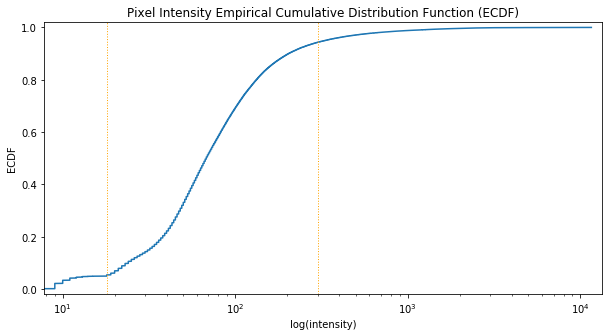

In [18]:
# determine the best clipping value using an ECDF

import statsmodels.api as sm
ecdf = sm.distributions.ECDF(pixel_intensity_df.intensity)

f, ax1 = plt.subplots()
plt.plot(ecdf.x, ecdf.y)
f.set_figheight(5)
f.set_figwidth(10)
plt.xscale('log')
plt.xlabel('log(intensity)')
plt.ylabel('ECDF')
plt.axvline(x=18, linestyle=':', linewidth=1, color='orange')
plt.axvline(x=300, linestyle=':', linewidth=1, color='orange')
plt.margins(0.02)
plt.title("Pixel Intensity Empirical Cumulative Distribution Function (ECDF)")
plt.show()

In [19]:
# calculate the colour to represent the intensity
colour_map = cm.get_cmap(name='rainbow')
norm = colors.LogNorm(vmin=1, vmax=1000, clip=True)  # aiming to get good colour variation in the lower range, and clipping everything else


In [39]:
%%time

colours_l = []
for i in pixel_intensity_df.intensity.unique():
    colours_l.append((i, colour_map(norm(i), bytes=True)[:3]))

colours_df = pd.DataFrame(colours_l, columns=['intensity','colour'])
pixel_intensity_df = pd.merge(pixel_intensity_df, colours_df, how='left', left_on=['intensity'], right_on=['intensity'])

CPU times: user 602 ms, sys: 3.47 ms, total: 605 ms
Wall time: 604 ms


In [40]:
len(pixel_intensity_df)

200378

In [41]:
pixel_intensity_df.head()

,tile_id,pixel_x,scan,intensity,colour
0,15,213,815,100,"(212, 220, 127)"
1,16,63,734,9,"(34, 214, 223)"
2,16,769,708,80,"(196, 232, 138)"
3,16,769,710,21,"(96, 250, 196)"
4,16,769,724,113,"(222, 212, 120)"


In [42]:
pixel_intensity_df.loc[pixel_intensity_df.intensity.idxmax()]

tile_id               34
pixel_x              118
scan                  78
intensity          11599
colour       (255, 0, 0)
Name: 76944, dtype: object

In [43]:
tile_33_df = pixel_intensity_df[(pixel_intensity_df.tile_id == 33)]

In [44]:
tile_33_df.head()

,tile_id,pixel_x,scan,intensity,colour
64408,33,13,89,96,"(210, 222, 128)"
64409,33,13,92,112,"(220, 214, 122)"
64410,33,13,97,74,"(190, 236, 142)"
64411,33,13,102,76,"(192, 234, 140)"
64412,33,13,106,81,"(196, 232, 138)"


In [45]:
%%time

# create an image of the whole frame
tile_im_array = np.zeros([PIXELS_Y+1, PIXELS_X+1, 3], dtype=np.uint8)  # container for the image
for r in zip(tile_33_df.pixel_x, tile_33_df.scan, tile_33_df.colour):
    x = r[0]
    y = r[1]
    c = r[2]
    tile_im_array[y,x,:] = c

CPU times: user 21.7 ms, sys: 1.15 ms, total: 22.9 ms
Wall time: 21.6 ms


In [46]:
tile_im_array.shape

(911, 911, 3)

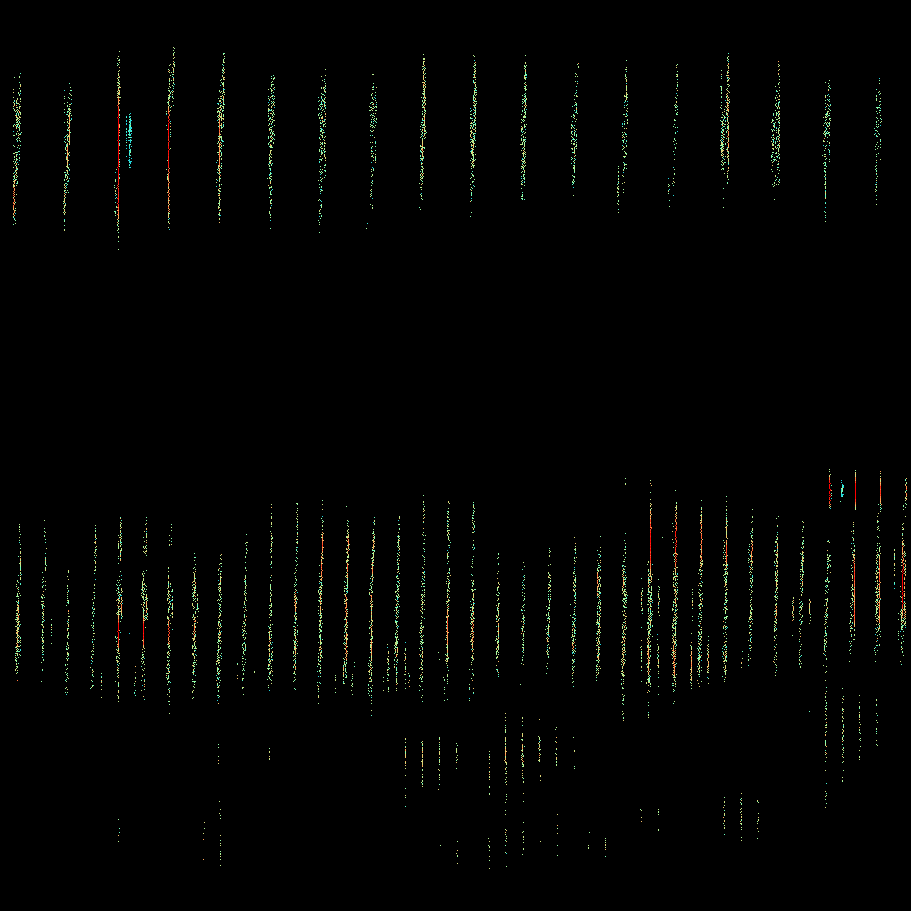

In [47]:
tile = Image.fromarray(tile_im_array, 'RGB')
tile

In [48]:
tile.save('/Users/darylwilding-mcbride/Downloads/prototype-tile.png')

In [50]:
%%time

for x in range(4, PIXELS_X-4):
    for y in range(4, PIXELS_Y-4):
        c = tile_im_array[y,x]
        if (not c.any()) and tile_im_array[y-4:y+4,x-1:x+1].any():  # this is a zero pixel and there is a non-zero pixel in this region
            n = []
            n.append(tile_im_array[y+1,x-1])
            n.append(tile_im_array[y+1,x])
            n.append(tile_im_array[y+1,x+1])

            n.append(tile_im_array[y-1,x-1])
            n.append(tile_im_array[y-1,x])
            n.append(tile_im_array[y-1,x+1])

            n.append(tile_im_array[y+2,x-1])
            n.append(tile_im_array[y+2,x])
            n.append(tile_im_array[y+2,x+1])

            n.append(tile_im_array[y-2,x-1])
            n.append(tile_im_array[y-2,x])
            n.append(tile_im_array[y-2,x+1])

            n.append(tile_im_array[y+3,x-1])
            n.append(tile_im_array[y+3,x])
            n.append(tile_im_array[y+3,x+1])

            n.append(tile_im_array[y-3,x-1])
            n.append(tile_im_array[y-3,x])
            n.append(tile_im_array[y-3,x+1])

            n.append(tile_im_array[y+4,x-1])
            n.append(tile_im_array[y+4,x])
            n.append(tile_im_array[y+4,x+1])

            n.append(tile_im_array[y-4,x-1])
            n.append(tile_im_array[y-4,x])
            n.append(tile_im_array[y-4,x+1])

            n.append(tile_im_array[y,x-1])
            n.append(tile_im_array[y,x+1])

            neighbours_a = np.array(n)
            tile_im_array[y,x] = np.mean(neighbours_a, axis=0)

CPU times: user 3.59 s, sys: 4.88 ms, total: 3.6 s
Wall time: 3.6 s


In [83]:
%%timeit

for x in range(4, PIXELS_X-4):
    for y in range(4, PIXELS_Y-4):
        c = tile_im_array[y,x]
        n = tile_im_array[y-4:y+5,x-1:x+2]
        if (not c.any()) and n.any():  # this is a zero pixel and there is a non-zero pixel in this region
            neighbours_a = einops.rearrange(n, 'h w c -> (h w) c')
            tile_im_array[y,x] = np.mean(neighbours_a, axis=0)

3.39 s ± 35.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
neighbours_a.shape

(27, 3)

In [84]:
%%timeit

for x in range(4, PIXELS_X-4):
    for y in range(4, PIXELS_Y-4):
        c = tile_im_array[y,x]
        n = tile_im_array[y-4:y+5,x-1:x+2]
        if (not c.any()) and n.any():  # this is a zero pixel and there is a non-zero pixel in this region
            n = n.reshape((27, 3))
            tile_im_array[y,x] = np.mean(n, axis=0)

3.21 s ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [79]:
n = tile_im_array[y-4:y+5,x-1:x+2]
n = n.reshape((27, 3))
n.shape

(27, 3)

In [85]:
tile_im_array[y-4:y+5,x-1:x+2].shape

(9, 3, 3)

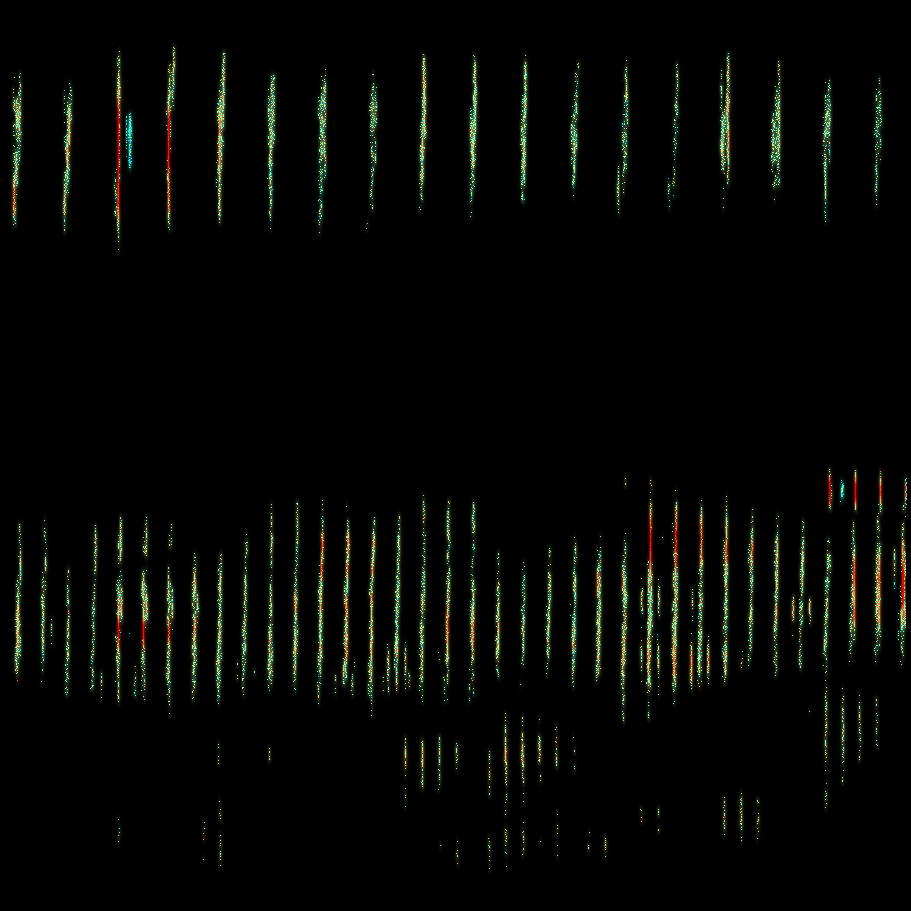

In [81]:
tile = Image.fromarray(tile_im_array, 'RGB')
tile

In [ ]:
tile.save('/Users/darylwilding-mcbride/Downloads/prototype-tile-average-filled.png')